In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Read the Excel file
df = pd.read_excel(r"C:\Users\PC\Downloads\data.xlsx", usecols = 'A:H')
df.head()

,month,date,user_id,sku_code,sku_price,recipient_network_provider,recipient_type,total_trans
0,2024-01-01,2024-01-03,248518,DC_ADDON_15GB,180000,Mobifone,other,1
1,2024-01-01,2024-01-05,712436,DC_ADDON_15GB,180000,Mobifone,other,1
2,2024-01-01,2024-01-17,224559,DC_ADDON_15GB,180000,Mobifone,other,1
3,2024-01-01,2024-01-24,235782,DC_ADDON_15GB,180000,Mobifone,other,1
4,2024-01-01,2024-01-20,194837,DC_ADDON_15GB,180000,Mobifone,other,1


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693257 entries, 0 to 693256
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   month                       693257 non-null  object
 1   date                        693257 non-null  object
 2   user_id                     693257 non-null  int64 
 3   sku_code                    693257 non-null  object
 4   sku_price                   693257 non-null  int64 
 5   recipient_network_provider  693257 non-null  object
 6   recipient_type              693257 non-null  object
 7   total_trans                 693257 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 42.3+ MB
None


In [17]:
print(df.describe())

            user_id      sku_price    total_trans
count  6.932570e+05  693257.000000  693257.000000
mean   3.845714e+05   21142.445010       1.049654
std    2.434089e+05   28485.659715       0.305505
min    2.000000e+00    1000.000000       1.000000
25%    2.140380e+05    9000.000000       1.000000
50%    2.323780e+05   10000.000000       1.000000
75%    7.128300e+05   15000.000000       1.000000
max    1.200644e+06  300000.000000      97.000000


In [18]:
# Check for duplicates
print(df.duplicated().sum())

965


In [19]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [20]:
print(df.isnull().sum())

month                         0
date                          0
user_id                       0
sku_code                      0
sku_price                     0
recipient_network_provider    0
recipient_type                0
total_trans                   0
dtype: int64


In [21]:
print(df.describe())

            user_id      sku_price    total_trans
count  6.922920e+05  692292.000000  692292.000000
mean   3.846106e+05   21152.298452       1.049723
std    2.434326e+05   28499.689916       0.305712
min    2.000000e+00    1000.000000       1.000000
25%    2.140370e+05    9000.000000       1.000000
50%    2.323970e+05   10000.000000       1.000000
75%    7.128322e+05   15000.000000       1.000000
max    1.200644e+06  300000.000000      97.000000


## RFM Analysis

In [22]:
# Convert date columns to datetime type
df.month = pd.to_datetime(df.month)
df.date = pd.to_datetime(df.date)

# Add amount column
df['amount'] = df.sku_price*df.total_trans

In [23]:
# Define the end date for the analysis period (assuming the latest date in the dfset)
end_date = df.date.max() + dt.timedelta(days=1)

# Group by user_id to calculate RFM metrics
rfm = df.groupby('user_id').agg({
    'date': lambda x: (end_date - x.max()).days,  # Recency
    'total_trans': 'sum',  # Frequency
    'amount': 'sum'  # Monetary
}).rename(columns={
    'date': 'recency',
    'total_trans': 'frequency',
    'amount': 'monetary'
}).reset_index()

# Display the RFM table
rfm.head(10)

,user_id,recency,frequency,monetary
0,2,173,1,10000
1,160521,5,2,170000
2,160524,105,1,90000
3,160610,115,1,90000
4,160611,123,1,13000
5,160613,143,1,10000
6,160614,36,3,189000
7,160616,26,4,168000
8,160617,31,3,49000
9,160622,179,1,5000


In [24]:
segmented_rfm = rfm.copy()

In [25]:
segmented_rfm["R_score"] = pd.qcut(segmented_rfm["recency"],4,labels=[4,3,2,1])

segmented_rfm["F_score"] = pd.qcut(segmented_rfm["frequency"].rank(method="first"),4,labels=[1,2,3,4])

segmented_rfm["M_score"] = pd.qcut(segmented_rfm["monetary"],4,labels=[1,2,3,4])

segmented_rfm["rfm_segmented"]=segmented_rfm["R_score"].astype("str")+segmented_rfm["F_score"].astype("str")+segmented_rfm["M_score"].astype("str")

segmented_rfm['RFM_Score'] = segmented_rfm[['R_score','F_score','M_score']].sum(axis=1)

segmented_rfm.head(10)

,user_id,recency,frequency,monetary,R_score,F_score,M_score,rfm_segmented,RFM_Score
0,2,173,1,10000,1,1,1,111,3
1,160521,5,2,170000,4,2,4,424,10
2,160524,105,1,90000,1,1,3,113,5
3,160610,115,1,90000,1,1,3,113,5
4,160611,123,1,13000,1,1,1,111,3
5,160613,143,1,10000,1,1,1,111,3
6,160614,36,3,189000,2,2,4,224,8
7,160616,26,4,168000,3,3,4,334,10
8,160617,31,3,49000,3,2,2,322,7
9,160622,179,1,5000,1,1,1,111,3


In [26]:
segmented_rfm.groupby('RFM_Score').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count'] }).round(1)

recency frequency  monetary       
             mean      mean      mean  count
RFM_Score                                   
3           130.9       1.0   10086.1  13297
4            92.7       1.3   15768.1  13288
5            80.0       1.6   37038.3  14273
6            56.8       2.2   44502.3  14509
7            45.7       3.0   63121.2  13599
8            34.7       4.0   85375.2  13853
9            26.5       5.4  114179.8  13431
10           21.3       7.6  162884.0  13026
11           13.6      11.2  233509.4  13833
12            5.4      16.2  340130.6  13678

## K-means clustering

In [27]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

recency's: Skew: 1.0239079271865423, : SkewtestResult(statistic=129.46937345442456, pvalue=0.0)
frequency's: Skew: 3.024375410731403, : SkewtestResult(statistic=249.0951284558551, pvalue=0.0)
monetary's: Skew: 2.6637790930620358, : SkewtestResult(statistic=234.05273985202663, pvalue=0.0)


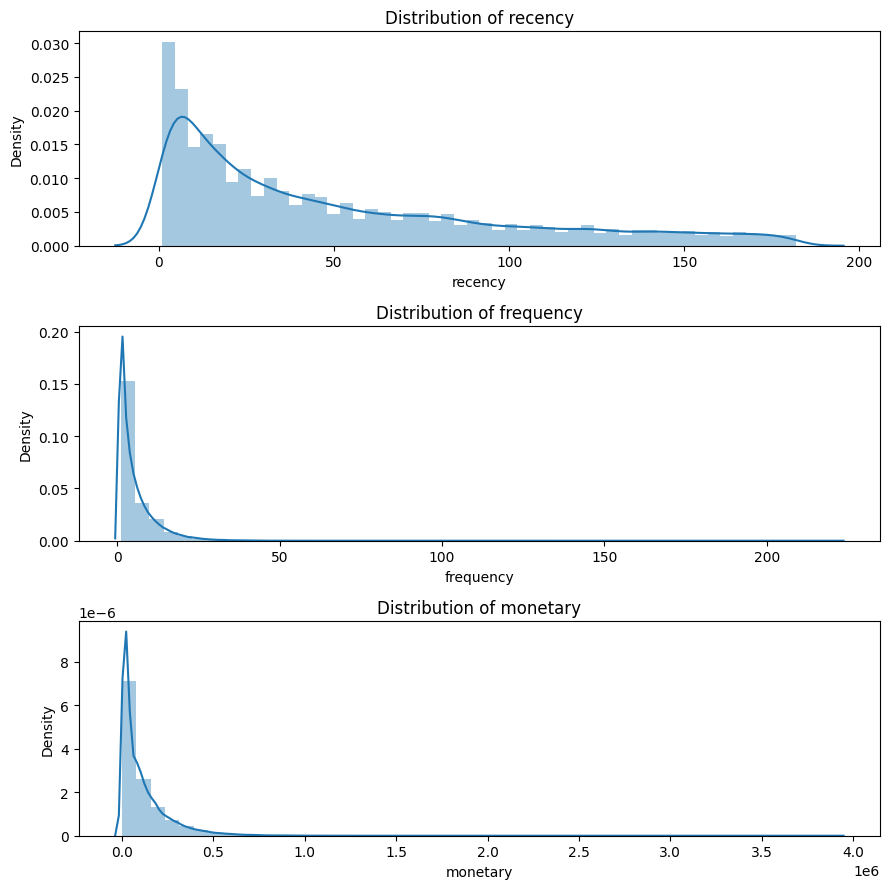

In [28]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm,'recency')

plt.subplot(3, 1, 2)
check_skew(rfm,'frequency')

plt.subplot(3, 1, 3)
check_skew(rfm,'monetary')

plt.tight_layout()

In [29]:
df_rfm_log = rfm.copy()
df_rfm_log.head()

,user_id,recency,frequency,monetary
0,2,173,1,10000
1,160521,5,2,170000
2,160524,105,1,90000
3,160610,115,1,90000
4,160611,123,1,13000


recency's: Skew: -0.45748177781702676, : SkewtestResult(statistic=-65.89661507189474, pvalue=0.0)
frequency's: Skew: 0.5496764431321299, : SkewtestResult(statistic=77.7449283951522, pvalue=0.0)
monetary's: Skew: -0.23829251730433265, : SkewtestResult(statistic=-35.48957203606202, pvalue=7.119242750418494e-276)


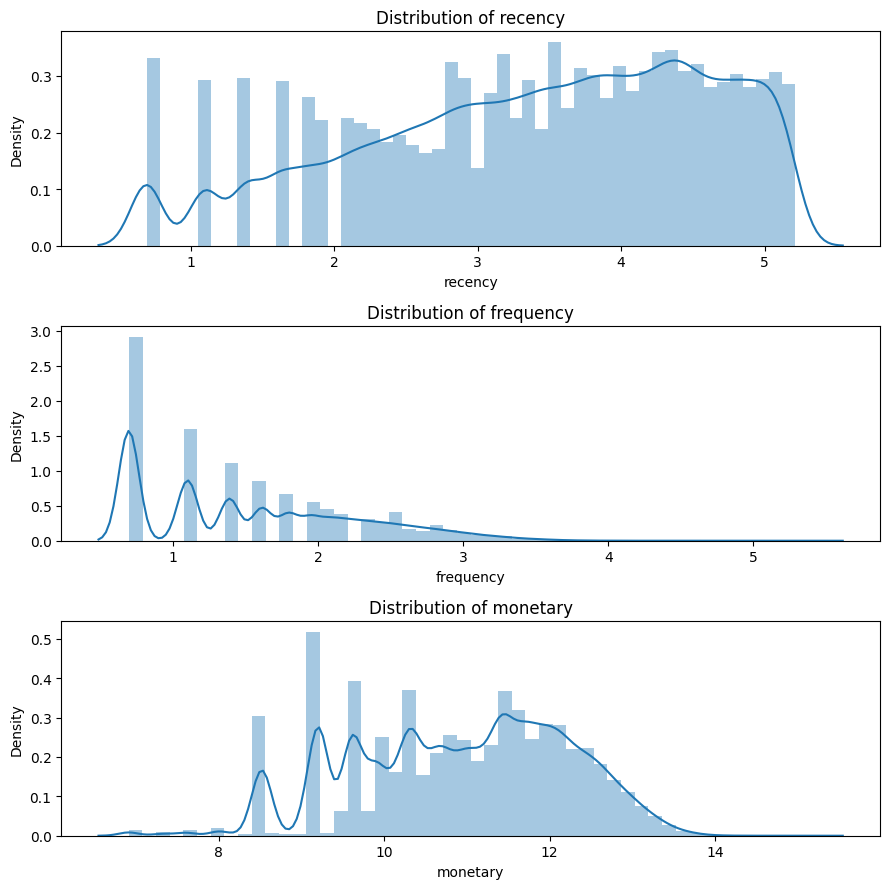

In [30]:
# perform log transformations to reduce the skewness
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'monetary')

plt.tight_layout()

In [31]:
# Eliminate outliers on both tails
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'recency', 'frequency', 'monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['recency', 'frequency', 'monetary'])

In [32]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [33]:
# Normalize RFM values
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [34]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,user_id,recency,frequency,monetary
0,-19.975613,1.505938,-1.155779,-1.339968
1,-1.386605,-1.373775,-0.596866,0.887075
2,-1.386573,1.082087,-1.155779,0.387144
3,-1.385658,1.159184,-1.155779,0.387144
4,-1.385648,1.216219,-1.155779,-1.133749


In [35]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    # generate the elbow plot
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show

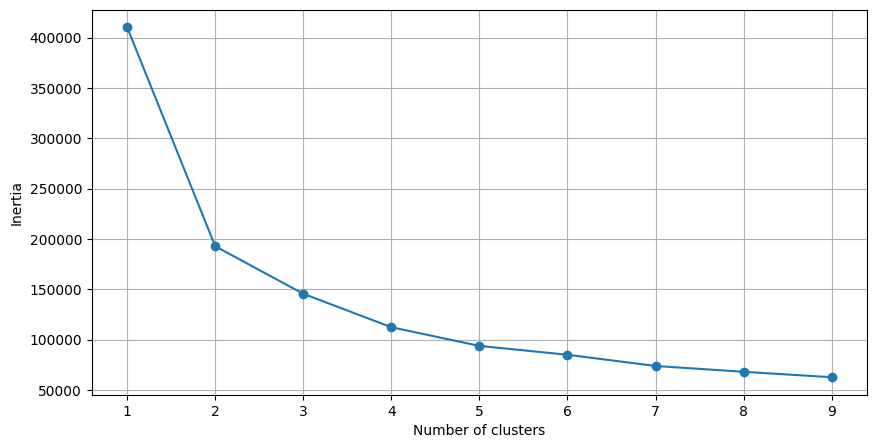

In [36]:
optimise_k_means(RFM_Table_scaled[['recency', 'frequency', 'monetary']], 10)

In [24]:
# # Choose the number of clusters of 4
# k_means = KMeans(n_clusters = 4, n_init='auto', random_state = 1)
# k_means.fit(RFM_Table_scaled[['recency', 'frequency', 'monetary']])

KMeans(n_clusters=4)

In [26]:
# RFM_Table_scaled['cluster'] = k_means.labels_
# rfm['cluster'] = k_means.labels_

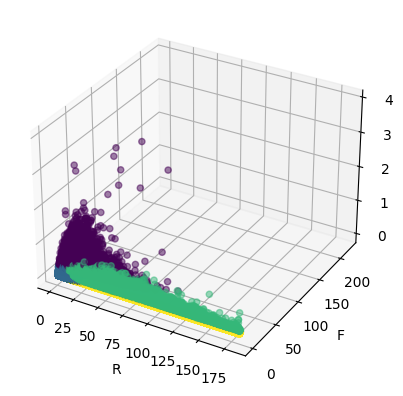

In [28]:
# from mpl_toolkits.mplot3d import Axes3D

# x = rfm['recency']
# y = rfm['frequency']
# z = rfm['monetary']
# colors = rfm['cluster']


# # Create a new figure for the 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Create the scatter plot
# ax.scatter(x, y, z, c=colors, marker='o', alpha=0.5)

# # Set labels
# ax.set_xlabel('R')
# ax.set_ylabel('F')
# ax.set_zlabel('M')

# # Show the plot
# plt.show()

In [37]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

In [ ]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 1, 1)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, rfm)

plt.tight_layout()

In [42]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=rfm.index, 
                                       columns=rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['user_id', 'Cluster'],
                        value_vars=['recency', 'frequency', 'monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

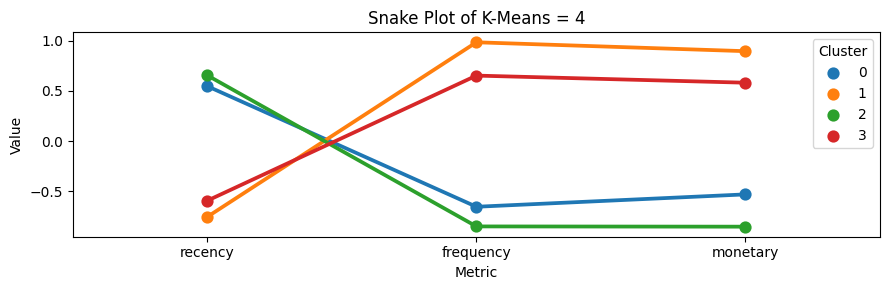

In [47]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, rfm)


plt.tight_layout()

In [48]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [49]:
rfm_values(df_rfm_k4)

recency frequency  monetary       
           mean      mean      mean  count
Cluster                                   
0          74.0       2.0   44330.0  42588
1          18.0      10.0  220009.0  39573
2          82.0       2.0   28902.0  31164
3          22.0       8.0  153513.0  23462